# **Outgassing Materials ML Modelling**

# Contents

1. **Define Goals**    

2. **Feature Engineering**


- Performance Score Calculation


3. **Initial Model Selection and Implementation**


    - Regression
        - Linear Regression
        - Random Forest Regressor
    - Regression Evaluation
        - MSE / R Squared
        - Ridge / Lasso

    - Classification
        - Logistic Regression
        - SVM
    - Classification Evaluation
        - Accuracy
        - Confusion Matrix
        - Classification Report 


4. **Best Model Selection**

5. **Conclusion**
    

# 1. **Define Goals**

**Objective**: 
1. Develop a `linear regression model` to evaluate and predict material performance based on material quality metrics (TML, CVCM, WVR).

2. Use `classification machine learning` to assess material reliability by predicting values for procurement and quality control.



**Understanding Features**: 

**CVCM**: This parameter measures the percentage of volatile material that can condense on a cold surface during the outgassing test. `Materials with lower CVCM values are preferable` for high-vacuum environments, as they release fewer contaminants .

**WVR**: This measures the amount of water vapor a material absorbs back after being subjected to Total Mass Loss (TML) and Collected Volatile Condensable Materials (CVCM) tests. Materials with high WVR values tend to absorb more moisture, which can lead to issues like corrosion, degradation, or reduced structural integrity. `Materials with lower WVR values are preferable`

**TML**: This measures the percentage of a material's mass lost during a test where the material is exposed to a high vacuum and temperature (125°C) for 24 hours. `A lower TML indicates better performance in vacuum environments.`

Importing libraries

In [47]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_blobs
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

reading CSV file

In [48]:
data = pd.read_csv(r'C:\Users\GGPC\IoD_Mini_Projects\Mini_Project_2\project_NASA_Materials_Project\data\result\cleaned_Outgassing_Db_20240702.csv')

material_df = pd.DataFrame(data)

In [49]:
material_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7559 entries, 0 to 7558
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               7559 non-null   object 
 1   Sample Material  7559 non-null   object 
 2   MFR              7559 non-null   object 
 3   TML              7559 non-null   float64
 4   Category         7559 non-null   int64  
 5   CVCM             7559 non-null   float64
 6   Space Code       7559 non-null   float64
 7   WVR              7559 non-null   float64
 8   Material Usage   7559 non-null   object 
dtypes: float64(4), int64(1), object(4)
memory usage: 531.6+ KB


In [50]:
material_df.head()

,ID,Sample Material,MFR,TML,Category,CVCM,Space Code,WVR,Material Usage
0,GSC33214,"""V"" MATERIAL IN CLICKBOND CB4023V, GLASS/PEI -...",CLB,0.37,12,0.00,1.0,0.35,CLICKBOND
1,GSC33217,"""VC"" MATERIAL IN CLICKBOND CB9257VC, CARBON FI...",CLB,0.52,12,0.00,1.0,0.28,CLICKBOND
2,GSC34174,0667 BLACK EPDM,PRS,0.65,15,0.13,1.0,0.07,ORING
3,GSC33829,1 INCH COPPER TAPE,MMM,0.24,16,0.08,1.0,0.01,TAPE
4,GSC33397,"100 DUN-LAM, GE COATED BLACK KAPTON XC",DUN,0.89,6,0.01,1.0,0.67,COND BLANKET FILM


# 2. **Feature Engineering**

Supplier performance evaluation
- To calculate supplier performance, we will use the following metrics:
    - **TML**: Total Material Loss 
    - **CVCM**: Cumulative Variance in Cost of Materials
    - **WVR**: Weighted Variance Ratio

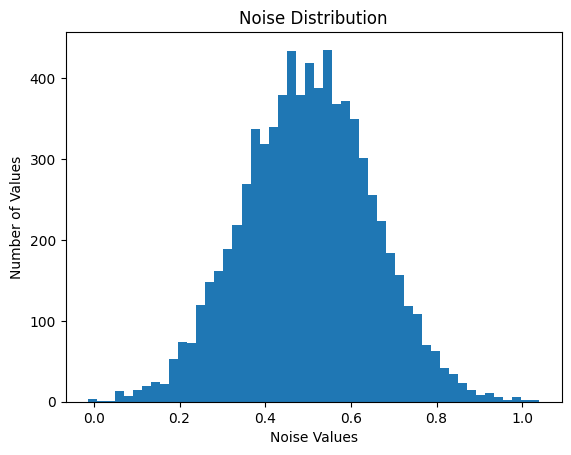

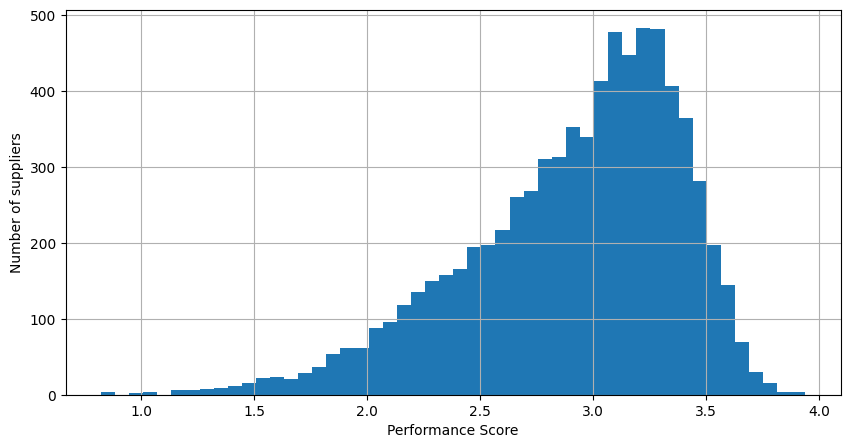

In [51]:
#performance score
# #adding noise to make the dataset a bit more realistic scenario
noise = np.random.normal(0.5, 0.15, size=material_df.shape[0])

# Normalize the features to a common scale
scaler = MinMaxScaler()
material_df[['TML', 'CVCM', 'WVR']] = scaler.fit_transform(material_df[['TML', 'CVCM', 'WVR']])

plt.hist(noise, bins=50)
plt.title("Noise Distribution")
plt.xlabel('Noise Values')
plt.ylabel('Number of Values')
plt.show()

# Calculate the performance score
material_df['performance_score'] = (1 - material_df['TML']) + (1 - material_df['CVCM']) + (1 - material_df['WVR']) + noise

#having a look at the distribution of the performance score
material_df['performance_score'].hist(bins=50, figsize=(10, 5))

plt.xlabel('Performance Score')
plt.ylabel('Number of suppliers')
plt.show()


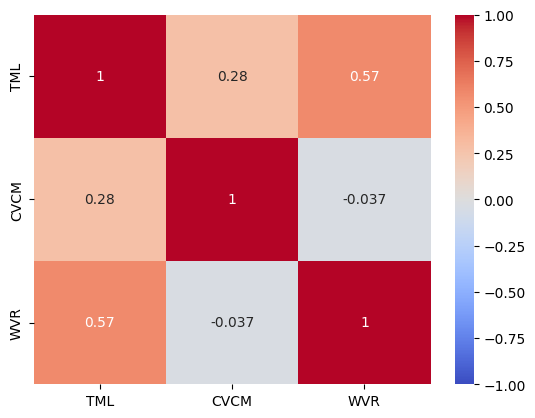

In [52]:
#correlation matrix
corr = material_df[['TML', 'CVCM', 'WVR']].corr()

sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='coolwarm', annot=True)
plt.show()


# 3. **Initial Model Selection and Implementation**

### Model Selection

- **Regression Models**: To predict the supplier performance score

    - Linear Regression
    - Random Forest Regressor

- **Classification Models**: To classify suppliers into performance categories (high, medium, low)

    - Logistic Regression
    - Random Forest Classifier
    - Support Vector Machine (SVM)

### Linear Regression Model

In [53]:
#feature and target
X = material_df[['TML', 'CVCM', 'WVR']]
y = material_df['performance_score']

In [54]:
#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [55]:
#scaling to maintain consistency with scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [56]:
# setting up model
lr_model = LinearRegression()

#fitting the training data to the model
lr_model.fit(X_train_scaled, y_train)

LinearRegression()

#### Predictions

In [57]:
# making predictions on test data
y_pred = lr_model.predict(X_test_scaled)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R_squared: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.023230547911823572
R_squared: 0.8969528310788608


#### Evaluation for linear regression

#### Ridge and Lasso Regularization

In [58]:
#model initialization
ridge_model = Ridge(alpha=0.05)
lasso_model = Lasso(alpha=0.05)

#splitting for ridge and lasso models
X_rnl = material_df[['TML', 'CVCM', 'WVR']]
y_rnl = material_df['performance_score']

X_train_rnl, X_test_rnl, y_train_rnl, y_test_rnl = train_test_split(X_rnl, y_rnl, test_size=0.2, random_state=1)

#to maintain consistency with scaling
scaler = MinMaxScaler()
X_train_rnl_scaled = scaler.fit_transform(X_train_rnl)
X_test_rnl_scaled = scaler.transform(X_test_rnl)

#model fitting
ridge_model.fit(X_train_rnl_scaled, y_train_rnl)
lasso_model.fit(X_train_rnl_scaled, y_train_rnl)
#predictions
ridge_predictions = ridge_model.predict(X_test_rnl_scaled)
lasso_predictions = lasso_model.predict(X_test_rnl_scaled)
#evaluating the mse
ridge_mse = mean_squared_error(y_test_rnl, ridge_predictions)
lasso_mse = mean_squared_error(y_test_rnl, lasso_predictions)
#evaluating r_squared
ridge_r2 = r2_score(y_test_rnl, ridge_predictions)
lasso_r2 = r2_score(y_test_rnl, lasso_predictions)
#printing the results
print(f'Ridge MSE: {ridge_mse}')
print(f'Ridge R_squared: {ridge_r2}\n')
print(f'Lasso MSE: {lasso_mse}')
print(f'Lasso R_squared: {lasso_r2}')



Ridge MSE: 0.023230511061749667
Ridge R_squared: 0.8969529945401707

Lasso MSE: 0.13419838893602679
Lasso R_squared: 0.4047164059097761


Adjusting Regularization Parameters

In [59]:
#looking for best parameters for ridge and lasso
ridge_params = {'alpha': [0.05, 0.1, 1, 10, 100]}
ridge_model_gs = GridSearchCV(Ridge(), ridge_params, cv=10)
ridge_model_gs.fit(X_train_rnl, y_train_rnl)
#printing the results
print(f"Best Ridge alpha: {ridge_model_gs.best_params_['alpha']}")

#testing the model with the best parameters
ridge_predictions = ridge_model_gs.predict(X_test_rnl)
ridge_mse = mean_squared_error(y_test_rnl, ridge_predictions)

print(f'Ridge MSE: {ridge_mse}')

Best Ridge alpha: 0.1
Ridge MSE: 0.023230480535056296


In [60]:
lasso_params = {'alpha': [0.05, 0.1, 1, 10, 100]}
lasso_model = GridSearchCV(Lasso(), lasso_params, cv=10)
lasso_model.fit(X_train, y_train)

print(f"Best Lasso alpha: {lasso_model.best_params_['alpha']}")

lasso_predictions = lasso_model.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_predictions)
lasso_r2 = r2_score(y_test, lasso_predictions)

print(f'Lasso MSE: {lasso_mse}')
print(f'Lasso R_squared: {lasso_r2}')

Best Lasso alpha: 0.05
Lasso MSE: 0.13419838893602679
Lasso R_squared: 0.4047164059097761


Random Forest Regressor Model

In [61]:
rf_model = RandomForestRegressor(n_estimators=10, random_state=1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [62]:
y_pred = rf_model.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R_squared: {r2_score(y_test, y_pred)}')

Mean Squared Error: 0.029571326268378603
R_squared: 0.8688261049732372


#### Thoughts
NOTE: lack of features and domain parameters / knowledge.

## Classification Model

Logistic Regression Model

In [63]:
# Performance Categories

#Dividing the performance score into 3 categories: Low, Medium, High
material_df['performance_category'] = pd.qcut(material_df['performance_score'], q=3, labels=['Low', 'Medium', 'High'])
material_df['performance_category']



0       Medium
1       Medium
2       Medium
3       Medium
4          Low
         ...  
7554       Low
7555    Medium
7556       Low
7557       Low
7558       Low
Name: performance_category, Length: 7559, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

In [64]:
# setting up feature and target
X = material_df[['TML', 'CVCM', 'WVR']]
y = material_df['performance_category']

#encoding the target variable
y = y.cat.codes

#spliting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [65]:
#scaling to maintain consistency with scaling
scaler = MinMaxScaler()
X_train_Lr_scaled = scaler.fit_transform(X_train)
X_test_Lr_scaled = scaler.transform(X_test)

In [66]:
# Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train_Lr_scaled, y_train)

LogisticRegression()

#### Predictions

In [67]:
#predictions
y_pred = logreg_model.predict(X_test_Lr_scaled)

#### Evaluation

In [68]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}\n")
print(f"Confusion Matrix:\n{conf_matrix}\n")
print(f"Classification Report:\n{class_report}")

Accuracy: 0.8015873015873016

Confusion Matrix:
[[444  65   0]
 [ 39 358 111]
 [  1  84 410]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.87      0.89       509
           1       0.71      0.70      0.71       508
           2       0.79      0.83      0.81       495

    accuracy                           0.80      1512
   macro avg       0.80      0.80      0.80      1512
weighted avg       0.80      0.80      0.80      1512



Here's the updated markdown based on the results from the image:

### Model Evaluation

| Metric               | Value        |
|----------------------|--------------|
| **Overall Accuracy** | 80.16%       |

### Confusion Matrix

#### Class 0:
|  | Predicted: Class 0 | Predicted: Class 1 | Predicted: Class 2 |
|---|---|---|---|
| **Actual: Class 0** | TP: 444 | FN: 65 | FN: 0 |
| **Actual: Class 1** | FP: 39 |  |  |
| **Actual: Class 2** | FP: 1 |  |  |

#### Class 1:
|  | Predicted: Class 0 | Predicted: Class 1 | Predicted: Class 2 |
|---|---|---|---|
| **Actual: Class 0** |  | FP: 39 |  |
| **Actual: Class 1** | FN: 65 | TP: 358 | FN: 111 |
| **Actual: Class 2** |  | FP: 84 |  |

#### Class 2:
|  | Predicted: Class 0 | Predicted: Class 1 | Predicted: Class 2 |
|---|---|---|---|
| **Actual: Class 0** |  |  | FP: 1 |
| **Actual: Class 1** |  | FN: 111 | FP: 84 |
| **Actual: Class 2** | FN: 0 | FN: 84 | TP: 410 |

### Explanation
- **Accuracy**: This means the model correctly predicted the class for `80.16%` of the samples.

- **Classification Report**:
  - **Precision**: The percentage of `correct positive predictions` for each class.
  - **Recall**: The percentage of `actual positives correctly identified`.
  - **F1 Score**: The `balance between precision and recall`.
  - **Support**: The `number of actual samples for each class`.

#### Classification Report Breakdown

### Class-wise Breakdown

#### Class 0:
- **Precision**: 0.92 (92%)
  - Out of all the predictions made for class 0, 92% were correct.
- **Recall**: 0.87 (87%)
  - Out of all the actual instances of class 0, 87% were correctly identified.
- **F1 Score**: 0.89 (89%)
  - This is a combined measure of precision and recall.
- **Support**: 509
  - There are 509 actual instances of class 0 in the dataset.

#### Class 1:
- **Precision**: 0.71 (71%)
  - Out of all the predictions made for class 1, 71% were correct.
- **Recall**: 0.70 (70%)
  - Out of all the actual instances of class 1, 70% were correctly identified.
- **F1 Score**: 0.71 (71%)
  - This is a combined measure of precision and recall.
- **Support**: 508
  - There are 508 actual instances of class 1 in the dataset.

#### Class 2:
- **Precision**: 0.79 (79%)
  - Out of all the predictions made for class 2, 79% were correct.
- **Recall**: 0.83 (83%)
  - Out of all the actual instances of class 2, 83% were correctly identified.
- **F1 Score**: 0.81 (81%)
  - This is a combined measure of precision and recall.
- **Support**: 495
  - There are 495 actual instances of class 2 in the dataset.

### Summary
- Class 0 has the highest precision (92%) and F1 score (89%), indicating strong performance in predicting this class.
- Class 1 has the lowest precision (71%) and F1 score (71%), indicating that predictions for this class are less accurate.
- Class 2 shows balanced performance with good precision (79%) and recall (83%), making it a reliable predictor for this class.

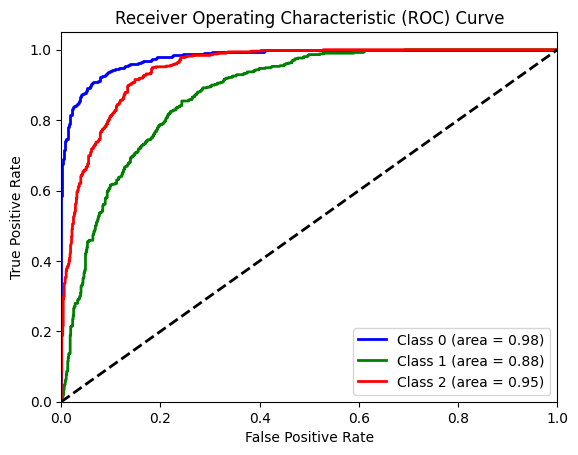

In [69]:
# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_pred_prob = logreg_model.predict_proba(X_test_Lr_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# forloop to go through each class and get fpr and tpr
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# forloop to Plot ROC curve for each class
plt.figure()
colors = ['blue', 'green', 'red']
for i, color in zip(range(3), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')
    

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Class 0 = Low Performance

Class 1 = Medium Performance

Class 2 = High Performance

## 4. **Model Selection**

**Selected models by overall evaluation scores**

- **Regression Model**: Linear Regression.

- **Classification Model**: Logistic Regression

## 5. **Conclusion**

- **Further Research Recommendations:**
    - Expand Dataset: Include more materials and suppliers to improve the models performance and accuracy.
    - Experiment with more Classification Models and improvement in evaluations of the models.
    - Incorporate Categorical Features: Analyze the impact of different material categories on performance.

- **Potential application of the Model:**
    - Optimized Material Selection: Leverage predictive analytics to choose the best materials for specific space applications, reducing costs and improving reliability.


    - Proactive Quality Control: Implement continuous monitoring systems to detect material performance issues early, preventing potential mission failures.


    - R&D Innovations: Apply model findings to drive research and development efforts, focusing on improving existing materials or developing new ones with superior performance characteristics.


---



---



# END


---



---